# Comparison of SpliceAI and S3 on biocurated cases



In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

#data_dir = "/Users/danisd/data/threes-simulations"
data_dir = "/home/ielis/data/threes-simulations"

## Load SpliceAI table

Load the table created by `spliceai-benchmark` code. During the loading, the table rows are filtered in order to:
- remove records representing variant effect with respect to different gene. If the variant is close to two overlapping transcripts of different genes, then it will be annotated with respect to both transcripts. We want to retain record representing annotation to a gene that is part of value in the `CASE` column
- remove records not representing `splicing|*` pathomechanism

After loading, we still will have records that have the same `CASE` id, these are mainly the cases with COMPHET inheritance and two variants both having `splicing|*` pathomechanism

In [2]:
from curation import load_spliceai_table

sai_path = os.path.join(data_dir, "splice-ai/spliceai-multi.tsv")
sai = load_spliceai_table(sai_path)
sai.head(n=2)

Loaded 571 records


,CASE,VARIANT,PATHOMECHANISM,ALLELE,SYMBOL,DS_AG,DS_AL,DS_DG,DS_DL,DP_AG,DP_AL,DP_DG,DP_DL,PATHOGRP
0,PMID:11828341-Ishii-2002-GLA-proband_1,X:100654735 C>T,splicing|SRE|ESS|binding|decreased,T,GLA,0.22,0.00,0.3,0.0,53.0,-1.0,-3.0,-59.0,SRE
1,PMID:28679633-Ito-2017-MYBPC3-VARIANT407-5C>T,11:47371668 G>A,splicing|3ss|disrupted,A,MYBPC3,0.01,0.18,0.0,0.0,-168.0,52.0,-93.0,-99.0,3ss|disrupted


## Load 3S table

Load the table created by `ExomiserSimulations | plain-threes` module.

In [3]:
from curation import load_threes_phenopacket_scores_table

version = "20190813"
threes_path = os.path.join(data_dir, "{0}-output-checked/{0}-phenopacket_scores.tsv".format(version))
tpp = load_threes_phenopacket_scores_table(threes_path)
tpp.head(n=2)

,CASE,VARIANT,TRANSCRIPT,VCLASS,PATHOMECHANISM,CONSEQUENCE,MAX_SCORE,CANONICAL_DONOR,CRYPTIC_DONOR,CRYPTIC_DONOR_IN_CANONICAL_POSITION,CANONICAL_ACCEPTOR,CRYPTIC_ACCEPTOR,CRYPTIC_ACCEPTOR_IN_CANONICAL_POSITION,SMS,PATHOGRP
0,PMID:11828341-Ishii-2002-GLA-proband_1,X:100654735 C>T,NM_000169.2,splicing,splicing|SRE|ESS|binding|decreased,Pseudoexon inclusion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SRE
1,PMID:28679633-Ito-2017-MYBPC3-VARIANT407-5C>T,11:47371668 G>A,NM_000256.3,splicing,splicing|3ss|disrupted,Exon skipping,0.646718,NaN,NaN,NaN,0.646718,NaN,0.622802,NaN,3ss|disrupted


## Compare 3S and SpliceAI results

Let's compare how the `3S` scores correlate with `SpliceAI` scores.

### 1) Merge the 3S and SpliceAI tables

Both *3S* and *SpliceAI* were used to score the same variants. Let's merge the dataframes by common unique identifier columns `CASE` and `VARIANT` and then melt in order to create `SCORER`, `SCORE` columns.

In [4]:
st = pd.merge(sai, tpp.drop(columns=['PATHOMECHANISM']), how='outer', on=('CASE', 'VARIANT', 'PATHOGRP'), suffixes=('_SAI', '_3S'))
st.head(n=2)

,CASE,VARIANT,PATHOMECHANISM,ALLELE,SYMBOL,DS_AG,DS_AL,DS_DG,DS_DL,DP_AG,...,VCLASS,CONSEQUENCE,MAX_SCORE,CANONICAL_DONOR,CRYPTIC_DONOR,CRYPTIC_DONOR_IN_CANONICAL_POSITION,CANONICAL_ACCEPTOR,CRYPTIC_ACCEPTOR,CRYPTIC_ACCEPTOR_IN_CANONICAL_POSITION,SMS
0,PMID:11828341-Ishii-2002-GLA-proband_1,X:100654735 C>T,splicing|SRE|ESS|binding|decreased,T,GLA,0.22,0.00,0.3,0.0,53.0,...,splicing,Pseudoexon inclusion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PMID:28679633-Ito-2017-MYBPC3-VARIANT407-5C>T,11:47371668 G>A,splicing|3ss|disrupted,A,MYBPC3,0.01,0.18,0.0,0.0,-168.0,...,splicing,Exon skipping,0.646718,NaN,NaN,NaN,0.646718,NaN,0.622802,NaN


In [5]:
stm = st.melt(id_vars=('CASE', 'VARIANT', 'PATHOMECHANISM', 'PATHOGRP'),
              value_vars=('DS_AG', 'DS_AL', 'DS_DG', 'DS_DL', 
                          'CANONICAL_DONOR', 'CRYPTIC_DONOR', 'CRYPTIC_DONOR_IN_CANONICAL_POSITION',
                          'CANONICAL_ACCEPTOR', 'CRYPTIC_ACCEPTOR', 'CRYPTIC_ACCEPTOR_IN_CANONICAL_POSITION'), 
              var_name='SCORER', value_name='VALUE')
stm.head(n=2)

,CASE,VARIANT,PATHOMECHANISM,PATHOGRP,SCORER,VALUE
0,PMID:11828341-Ishii-2002-GLA-proband_1,X:100654735 C>T,splicing|SRE|ESS|binding|decreased,SRE,DS_AG,0.22
1,PMID:28679633-Ito-2017-MYBPC3-VARIANT407-5C>T,11:47371668 G>A,splicing|3ss|disrupted,3ss|disrupted,DS_AG,0.01


### 2) How do results correlate?

Bla

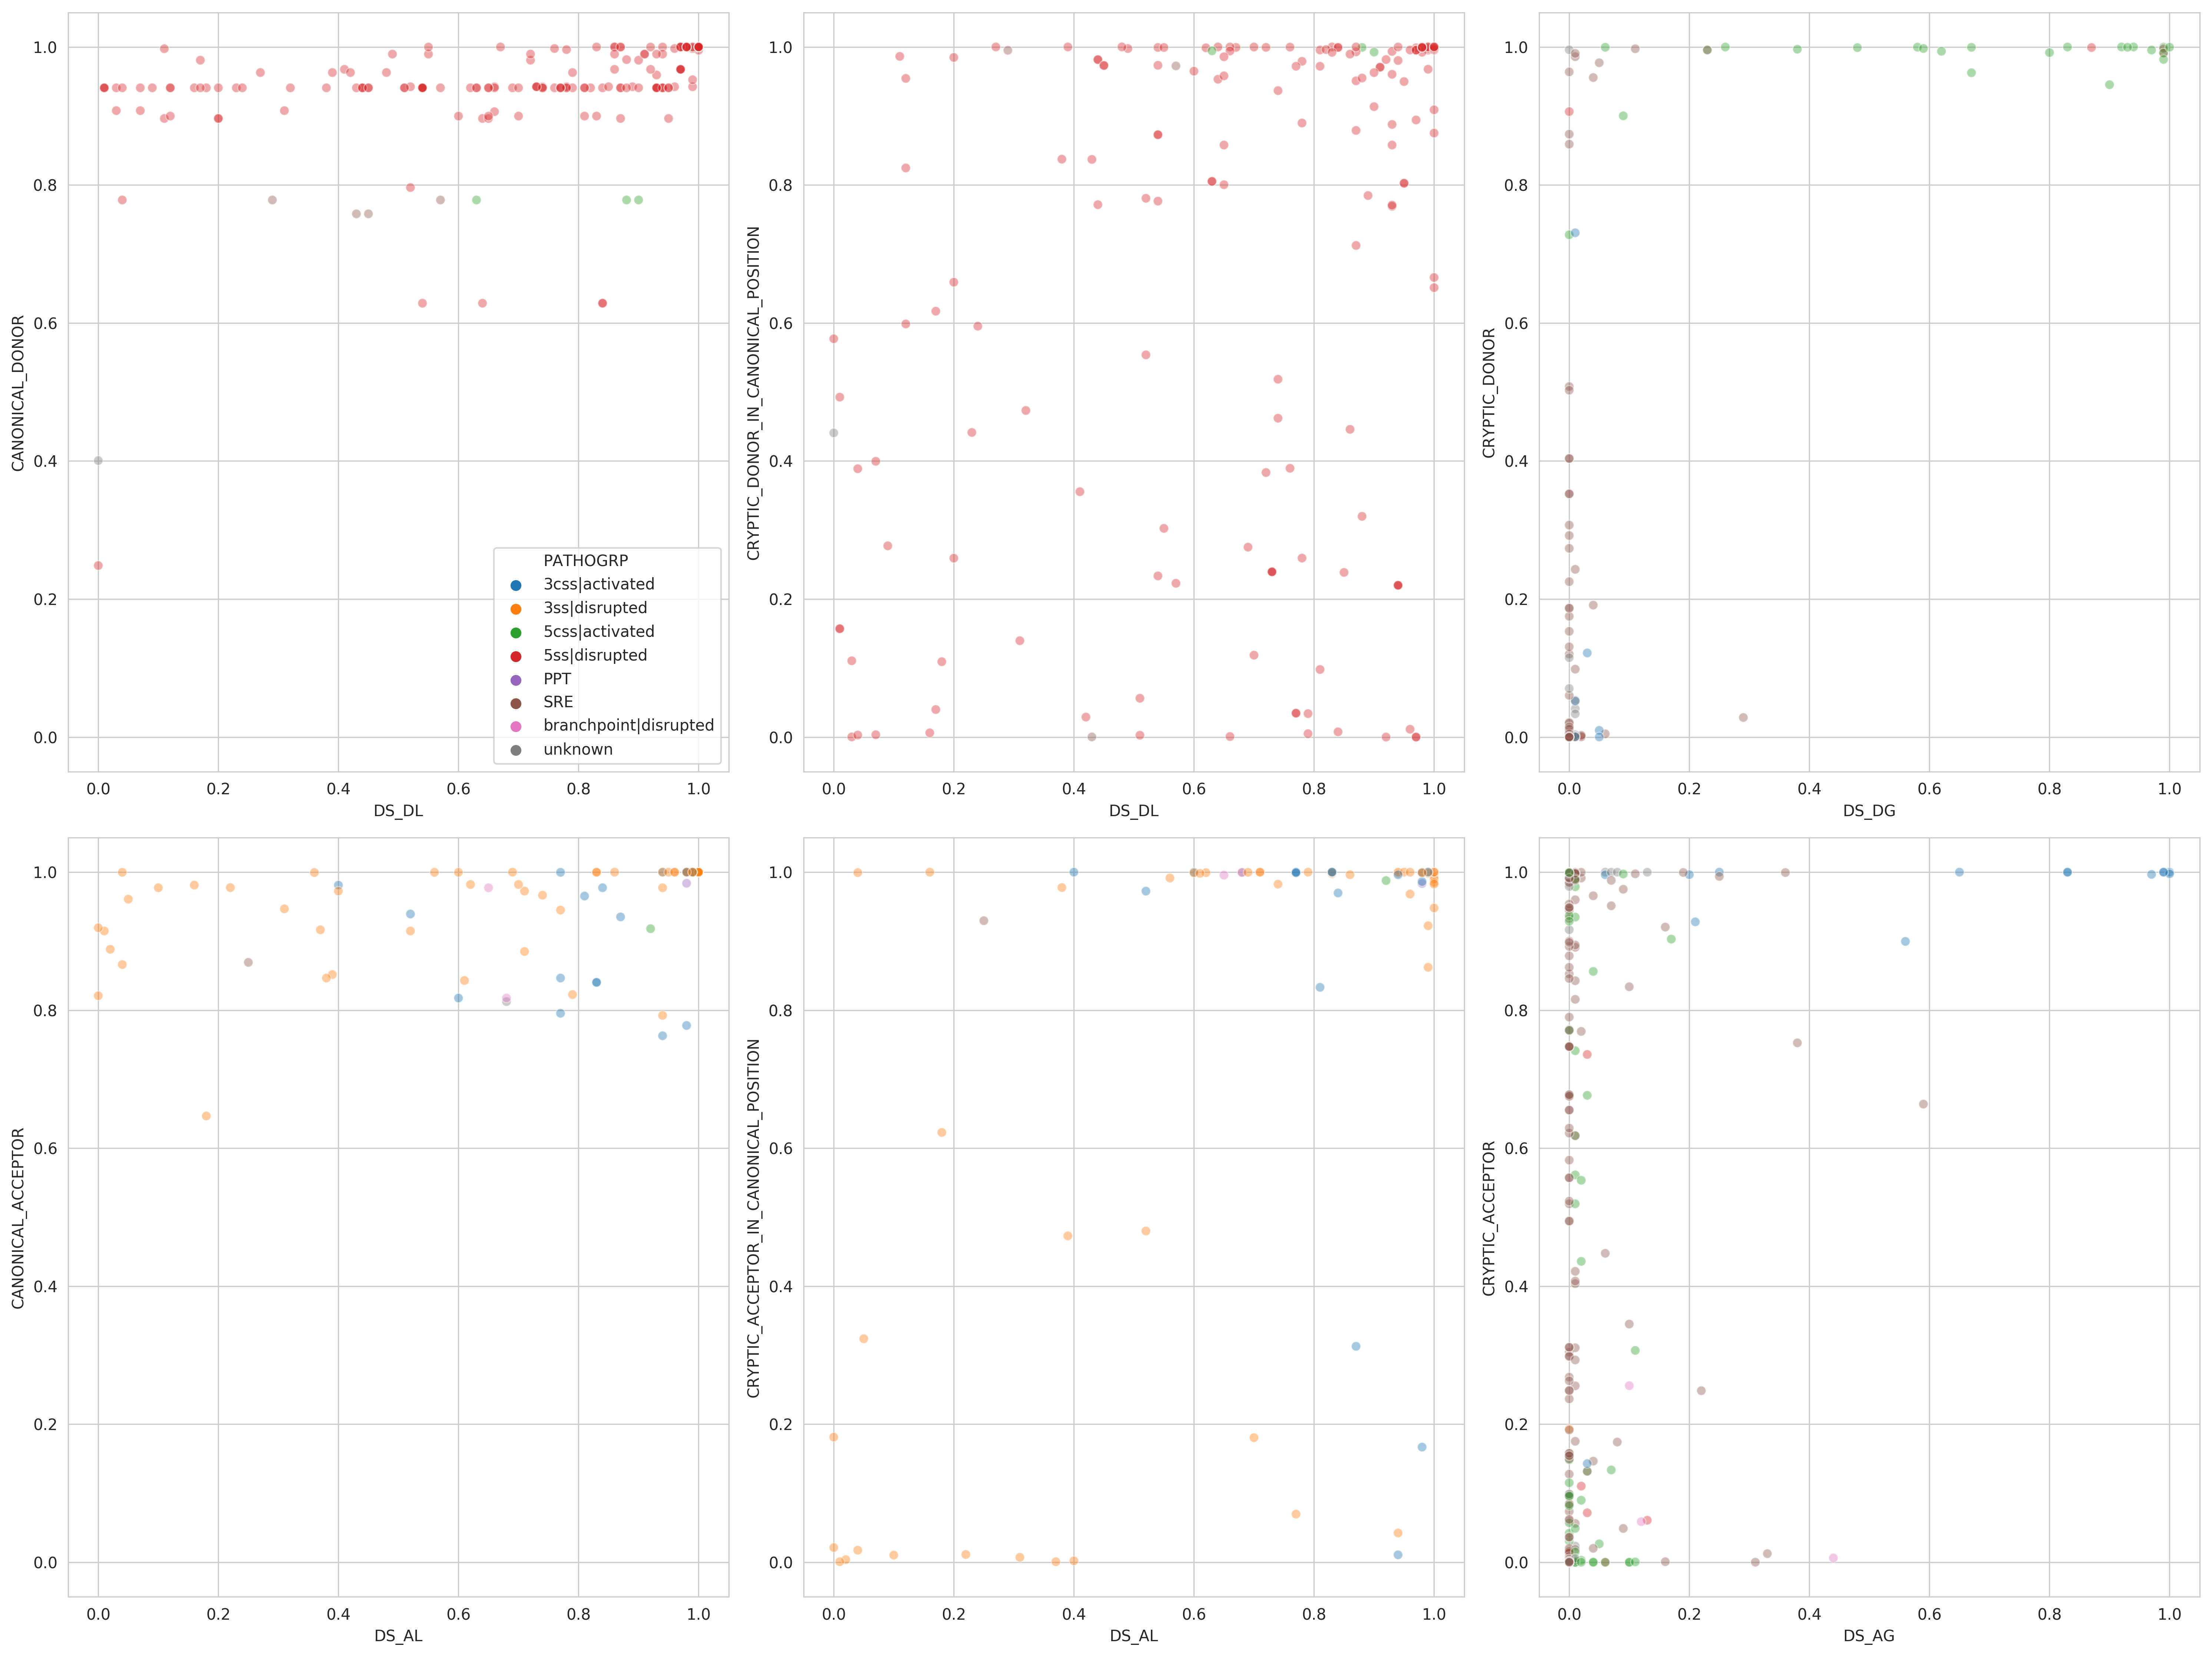

In [6]:
import math
pairs = [('DS_DL', 'CANONICAL_DONOR'), ('DS_DL', 'CRYPTIC_DONOR_IN_CANONICAL_POSITION'),       # CANONICAL DONOR
         ('DS_DG', 'CRYPTIC_DONOR'),                                                           # CRYPTIC DONOR
         ('DS_AL', 'CANONICAL_ACCEPTOR'), ('DS_AL', 'CRYPTIC_ACCEPTOR_IN_CANONICAL_POSITION'), # CANONICAL ACCEPTOR
         ('DS_AG', 'CRYPTIC_ACCEPTOR')]                                                        # CRYPTIC ACCEPTOR
        
ncols = 3
nrows = math.ceil(len(pairs) / ncols)
pathogrps = sorted(st.PATHOGRP.unique())
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 15), dpi=300)

legend_shown = False
for pair, ax in zip(pairs, axs.ravel()):
    xl = ax.set_xlim([-0.05, 1.05])
    yl = ax.set_ylim([-0.05, 1.05])
    sp = sns.scatterplot(pair[0], pair[1], hue='PATHOGRP', hue_order=pathogrps, alpha=.4, data=st, ax=ax)
    if legend_shown:
        ax.legend().remove()
    legend_shown = True
    
fig.tight_layout()

**Interpretation**

We have 6 subplots in the figure above, let's discuss all the subplots:

- `CANONICAL_DONOR` vs. `DONOR_LOSS`: here the variants 